# 多项式回归

多项式回归是指使用原始特征的多项式组合作为新的特征.

比如:
${h_\theta}\left( x \right)={\theta_{0}}+{\theta_{1}}{x_{1}}+{\theta_{2}}{x_{2}^2}+{\theta_{3}}{x_{3}^3}+{\theta_{4}}{x_{4}^4}$


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
from util import *

C:\Users\Alex\Anaconda3\envs\MachineLearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 读取数据

In [2]:
def load_data():
    """for ex5
    d['X'] shape = (12, 1)
    pandas has trouble taking this 2d ndarray to construct a dataframe, so I ravel
    the results
    """
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [3]:
X, y, Xval, yval, Xtest, ytest = load_data()

Text(0,0.5,'water flowing out the dam (y)')

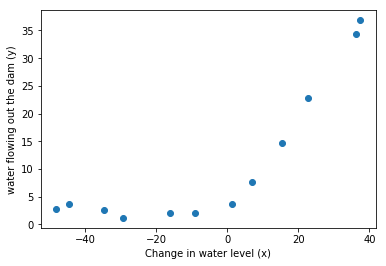

In [4]:
plt.scatter(X, y)
plt.xlabel('Change in water level (x)')
plt.ylabel('water flowing out the dam (y)')

In [5]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

### 含正则化的正规方程

正规方程
![](../images/71d723ddb5863c943fcd4e6951114ee3.png)

In [6]:
def regularized_normalEqn(X, y, lam=1):
    n = X.shape[1]
    temp = np.eye(n)
    temp[0,0] = 0
    theta = np.linalg.inv(X.T@X + lam * temp)@X.T@y#X.T@X等价于X.T.dot(X)
    return theta

In [7]:
theta = regularized_normalEqn(X, y, 1)
print(theta)

[13.08771416  0.367742  ]


### 含正则化的代价函数

代价函数$J\left( \theta  \right)=\frac{1}{2m}[\sum\limits_{i=1}^{m}{{{({h_\theta}({{x}^{(i)}})-{{y}^{(i)}})}^{2}}+\lambda \sum\limits_{j=1}^{n}{\theta_{j}^{2}}]}$, 使用向量化表示为: $J(\theta)=\frac1{2m}{(X\theta-y)}^T(x\theta-y) + \lambda \sum\limits_{j=1}^{n}{\theta_{j}^{2}}$

注意: 含正则化的代价函数只在训练时使用, 在计算交叉验证集和测试集时注意将lambda设置为0


In [8]:
def regularized_cost(theta, X, y, lam=0):
    m = X.shape[0]

    regularized_term = (lam / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

### 含正则化的梯度函数

梯度函数${\theta_j}:={\theta_j}(1-a\frac{\lambda }{m})-a\frac{1}{m}\sum\limits_{i=1}^{m}{({h_\theta}({{x}^{(i)}})-{{y}^{(i)}})x_{j}^{\left( i \right)}}, j>0$, 

使用向量化表示为: $\frac{\partial}{{\partial}{\theta}}{J({\theta})}=\frac1mX^T(X{\theta} - y) + \frac{\lambda}{m}\theta, j>0$


$j=0$时, ${\theta_j}:={\theta_j}-a\frac{1}{m}\sum\limits_{i=1}^{m}{({h_\theta}({{x}^{(i)}})-{{y}^{(i)}})x_{j}^{\left( i \right)}}$

In [9]:
def regularized_gradient(theta, X, y, lam=0):
    m = X.shape[0]

    regularized_term = theta.copy()  # same shape as theta
    regularized_term[0] = 0  # don't regularize intercept theta
    regularized_term = (lam / m) * regularized_term

    return gradient(theta, X, y) + regularized_term

### 含正则化的线性回归

In [10]:
def linear_regression_np(X, y, lam=0):
    """linear regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # init theta
    theta = np.ones(X.shape[1])

    # train it
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, lam),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    return res

### $\lambda$为0, 不含多项式特征

可以明显看出欠拟合

In [11]:
theta = np.ones(X.shape[0])

final_theta = linear_regression_np(X, y, lam=0).get('x')

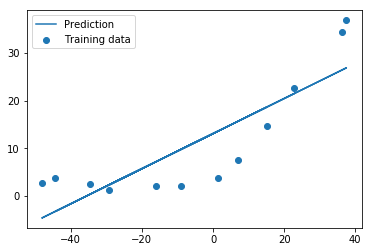

In [12]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

plt.scatter(X[:,1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

### 绘制学习曲线

In [13]:
def plot_learning_curve(X, y, Xval, yval, lam=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        # regularization applies here for fitting parameters
        res = linear_regression_np(X[:i, :], y[:i], lam=lam)

        # remember, when you compute the cost here, you are computing
        # non-regularized cost. Regularization is used to fit parameters only
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.xlabel('size of trainning examples0')
    plt.ylabel('cost')
    plt.legend(loc=1)

### 学习曲线: lambda = 0, 不含有多项式特征

对比后面的学习曲线可以看出, 最终的测试误差和交叉验证集误差都保持在较高的位置. 欠拟合了

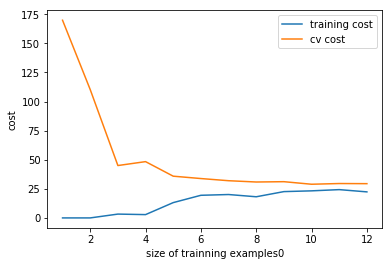

In [14]:
plot_learning_curve(X, y, Xval, yval, lam=0)

### 多项式特征

In [15]:
def prepare_poly_data(*args, power):
    """
    args: keep feeding in X, Xval, or Xtest
        will return in the same order
    """
    def prepare(x):
        # expand feature
        df = poly_features(x, power=power)

        # normalization
        ndarr = normalize_feature(df).as_matrix()

        # add intercept term
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(x) for x in args]

In [16]:
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)

    return df.as_matrix() if as_ndarray else df


In [17]:
X, y, Xval, yval, Xtest, ytest = load_data()

X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3, :]

C:\Users\Alex\Anaconda3\envs\MachineLearning\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

### 可视化数据和拟合结果

In [18]:
print(X)
print(y)

[-15.93675813 -29.15297922  36.18954863  37.49218733 -48.05882945
  -8.94145794  15.30779289 -34.70626581   1.38915437 -44.38375985
   7.01350208  22.76274892]
[ 2.13431051  1.17325668 34.35910918 36.83795516  2.80896507  2.12107248
 14.71026831  2.61418439  3.74017167  3.73169131  7.62765885 22.7524283 ]


In [19]:
def plot_poly_data(X, y, power=8, lam=0):
    X_poly, = prepare_poly_data(X, power=power)
    theta = linear_regression_np(X_poly, y, lam=lam).get('x')
    plt.scatter(X, y, label='raw data')
    _f = np.arange(X.min(), X.max(), 0.1)
    _poly = prepare_poly_data(_f, power=power)
    _prediction = _poly @ theta.T
    plt.scatter(_f, _prediction, label='regression')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()

### $\lambda$ = 1, 多项式级数=8

曲线过于复杂, 几乎贴合原数据. 过拟合了. 增加训练数据有助于解决这种情况. 也可以通过减少多项式特征或者增加$\lambda$来改善

C:\Users\Alex\Anaconda3\envs\MachineLearning\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


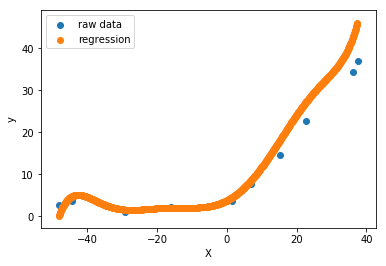

In [20]:
plot_poly_data(X, y, power=8, lam=0)

可以看到开始训练集的误差一直保持在0, 过拟合. 随着测试数据的增加, 交叉验证集的误差逐渐降低.

这个案例中的数据较少, 如果有更多数据的话(超过多项式能够完全拟合的个数), 训练集误差会稍有提高, 然后平缓. 与交叉验证集的误差收敛于同一处

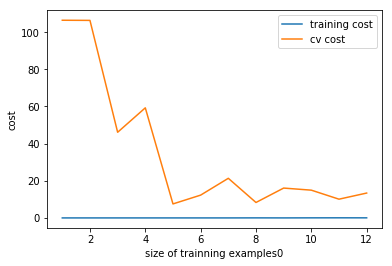

In [21]:
plot_learning_curve(X_poly, y, Xval_poly, yval, lam=0)
plt.show()

### $\lambda$ = 1, 多项式级数 = 8

这个曲线不过于复杂, 也反应了数据的特征. 拟合较好

C:\Users\Alex\Anaconda3\envs\MachineLearning\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


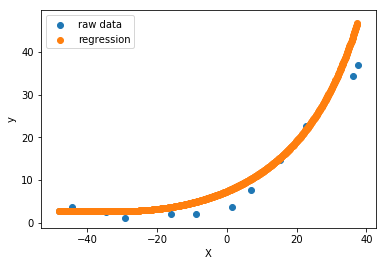

In [22]:
plot_poly_data(X, y, power=8, lam=1)

可以看到学习曲线很快就收敛了. 这种情况很大程度反应了模型的正确性.

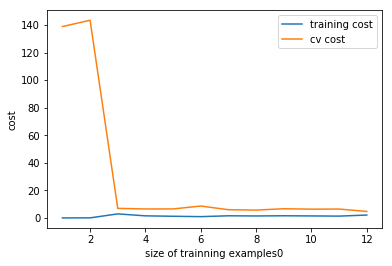

In [23]:
plot_learning_curve(X_poly, y, Xval_poly, yval, lam=1)
plt.show()

### $\lambda$ = 10, 多项式级数 = 8

欠拟合了. 增加训练数据不能改善情况. 需要对模型进行修改. 措施包括减少lambda或者增加多项式级数特征

C:\Users\Alex\Anaconda3\envs\MachineLearning\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


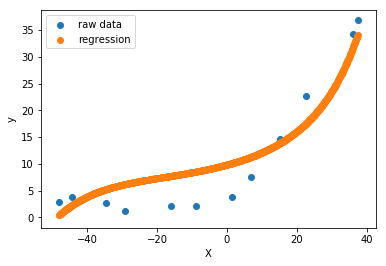

In [24]:
plot_poly_data(X, y, power=8, lam=10)

可以看出训练集的误差和交叉验证集的误差最终都保持在较高水平. 对比前面的约为3的误差, 明显看出欠拟合.

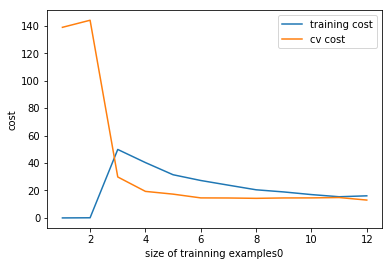

In [25]:
plot_learning_curve(X_poly, y, Xval_poly, yval, lam=10)
plt.show()

### 寻找最合适的 $\lambda$

可以看到在 $\lambda$ 为 1 的位置, 交叉验证集的代价达到最小. 此处是最合适的 $\lambda$ 值

In [26]:
lambda_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [27]:
for lam in lambda_candidate:
    res = linear_regression_np(X_poly, y, lam)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

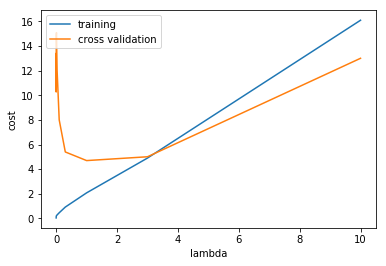

In [28]:
plt.plot(lambda_candidate, training_cost, label='training')
plt.plot(lambda_candidate, cv_cost, label='cross validation')
plt.legend(loc=2)
plt.xlabel('lambda')
plt.ylabel('cost')
plt.show()

In [29]:
# best cv I got from all those candidates
lambda_candidate[np.argmin(cv_cost)]

1

In [30]:
# use test data to compute the cost
for lam in lambda_candidate:
    theta = linear_regression_np(X_poly, y, lam).x
    print('test cost(l={}) = {}'.format(lam, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 10.122298845834932
test cost(l=0.001) = 10.989357236615056
test cost(l=0.003) = 11.26731092609127
test cost(l=0.01) = 10.881623900868235
test cost(l=0.03) = 10.02232745596236
test cost(l=0.1) = 8.632062332318977
test cost(l=0.3) = 7.336513212074589
test cost(l=1) = 7.466265914249742
test cost(l=3) = 11.643931713037912
test cost(l=10) = 27.7150802906621


### 我们也可以通过减少多项式特征来降低过拟合的情况

$\lambda$ = 0, 多项式级数=3

可以看出这也是一个较好的拟合, 不过一般如何选择多项式比较麻烦, 一般通过正则化降低过拟合的方法使用更多

C:\Users\Alex\Anaconda3\envs\MachineLearning\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


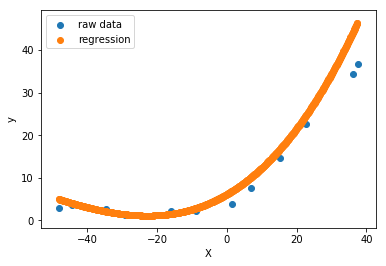

In [31]:
plot_poly_data(X, y, power=3, lam=0)

可以看出多项式级数 = 3, 已经不太可能导致欠拟合的情况

C:\Users\Alex\Anaconda3\envs\MachineLearning\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


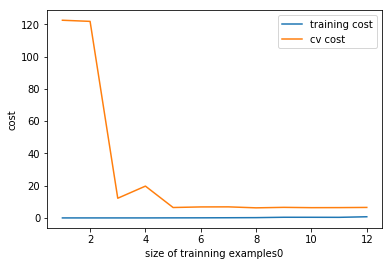

In [32]:
X_poly, Xval_poly, X_test = prepare_poly_data(X, Xval, Xtest, power=3)
plot_learning_curve(X_poly, y, Xval_poly, yval, lam=0)
plt.show()